<a href="https://colab.research.google.com/github/htapiagroup/sistdist/blob/master/SistDist2_S3_L3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
from math import sqrt

In [0]:
def f(z):
  return sqrt(z + 4)

def g(y):
  return y - 3

def h(x):
  return x ** 2

In [0]:
x = 4
y = h(x)
z = g(y)
w = f(z)

In [4]:
print(w)

4.123105625617661


In [5]:
print(f(g(h(x))))

4.123105625617661


In [0]:
data = [ 1, 2, 3, 4, 5 ]

In [7]:
for x in data:
  print(f(g(h(x))))

1.4142135623730951
2.23606797749979
3.1622776601683795
4.123105625617661
5.0990195135927845


In [9]:
%%time
[f(g(h(x))) for x in data] # comprension de listas

CPU times: user 28 µs, sys: 6 µs, total: 34 µs
Wall time: 39.1 µs


[1.4142135623730951,
 2.23606797749979,
 3.1622776601683795,
 4.123105625617661,
 5.0990195135927845]

La lista anterior se genera secuencialmente, como la podemos generar en forma paralela?


In [0]:
from dask import delayed

In [0]:
x = 4 
y = delayed(h)(x)
z = delayed(g)(y)
w = delayed(f)(z)

In [13]:
print(w)

Delayed('f-920960d1-ac8f-4fa7-b8e7-4d77da0d7566')


In [14]:
type(w)

dask.delayed.Delayed

In [17]:
w.compute()

4.123105625617661

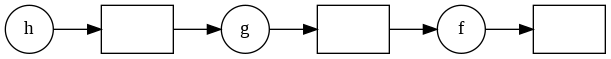

In [19]:
w.visualize(rankdir='LR')

In [0]:
def f(x):
  return sqrt(x + 4)

f = delayed(f)

In [22]:
@delayed
def f(x):
  return sqrt(x + 4)

print(type(f))

<class 'dask.delayed.DelayedLeaf'>


Ejemplo usando decoradores

In [24]:
data

[1, 2, 3, 4, 5]

In [0]:
output = []
for x in data:
  a = incrementa(x)
  b = dobla(x)
  c = suma(a, b)
  output.append(c)

In [26]:
type(output)

list

In [35]:
[out.compute() for out in output]

[4, 7, 10, 13, 16]

In [28]:
total = sum(output)
type(total)

dask.delayed.Delayed

In [0]:
total.visualize(rankdir='LR')

In [30]:
total.compute()

50

In [0]:
#@delayed
def incrementa(x):
  return x + 1

#@delayed
def dobla(x):
  return 2 * x

#@delayed
def suma(x, y):
  return x + y

In [37]:
type(suma)

function

In [40]:
%%time
a = delayed(incrementa)(1)
b = delayed(dobla)(2)
c = delayed(suma)(a, b)

CPU times: user 696 µs, sys: 0 ns, total: 696 µs
Wall time: 583 µs


In [41]:
%%time

c.compute()

CPU times: user 2.37 ms, sys: 894 µs, total: 3.26 ms
Wall time: 2.57 ms


6

Vamos a ejecutar un for en paralelo, 

In [0]:
from time import sleep

def inc(x):
    sleep(1)
    return x + 1

In [45]:
%%time
res = []
for x in data:
  y = inc(x)
  res.append(y)

total = sum(res)

CPU times: user 7.97 ms, sys: 2.99 ms, total: 11 ms
Wall time: 5.01 s


In [47]:
%%time 
res = []
for x in data:
  y = delayed(inc)(x)
  res.append(y)

total = delayed(sum)(res)
total.compute()

CPU times: user 7.73 ms, sys: 5.98 ms, total: 13.7 ms
Wall time: 3.01 s


# Ejercicio
Descargar los archivos de taxi
comparar el calculo siguiente entre el realizado con generadores y como sigue usando `delayed`

In [0]:
import os
plantilla = 'yellow_tripdata_2018-{:02d}.csv'
plantillaURL = 'wget https://s3.amazonaws.com/nyc-tlc/trip+data/'+plantilla
urls = (plantillaURL.format(k) for k in range(1,7)) # generator
for url in urls:
  os.system(url)

In [0]:
import pandas as pd

In [0]:
@delayed
def cuenta_viajes_largos(df):
  df['duracion'] = (df.tpep_dropoff_datetime - df.tpep_pickup_datetime).dt.seconds
  es_viaje_largo = df.duracion > 1200 # viajes que duran mas de 20 minutos
  result_dict = {'n_long':[sum(es_viaje_largo)],
                'n_total':[len(df)]}
  return pd.DataFrame(result_dict)

@delayed
def abre_archivo(nombre):
  return pd.read_csv(nombre, parse_dates=[1,2])

In [0]:
archivos = [plantilla.format(k) for k in range(1,7)] 

In [0]:
totales = [cuenta_viajes_largos(abre_archivo(archivo)) for archivo in archivos ]

In [0]:
semi_anuales = sum(totales)

In [0]:
semi_anuales.compute()

# Arreglos o matrices usando dask

In [0]:
import numpy as np

In [0]:
a = np.random.rand(10000)

In [57]:
print(a.shape, a.dtype, a.nbytes)

(10000,) float64 80000


In [58]:
a.sum()

4978.722357609479

In [59]:
a.mean()

0.4978722357609479

In [0]:
import dask.array as da

In [0]:
a_dask = da.from_array(a, chunks=len(a)//3)

In [62]:
type(a_dask)

dask.array.core.Array

In [80]:
a_dask.chunks

((3333, 3333, 3333, 1),)

In [0]:
n_chunks = 8
chunk_size = len(a) // n_chunks

result = 0

In [0]:
for k in range(n_chunks):
  offset = k*chunk_size
  a_chunk = a[offset:offset + chunk_size]
  result += a_chunk.sum()

In [71]:
print(result)

4978.722357609479


In [72]:
a.sum()

4978.722357609479

In [0]:
result_dask = a_dask.mean()

In [82]:
result_dask.compute()

0.49787223576094786

In [0]:
result_dask.visualize(rankdir='LR')

Medir el tiempo de computo sobre arreglos

In [84]:
!wget https://www.gw-osc.org/archive/data/S5/814743552/H-H1_LOSC_4_V1-815411200-4096.hdf5

--2019-05-21 18:19:40--  https://www.gw-osc.org/archive/data/S5/814743552/H-H1_LOSC_4_V1-815411200-4096.hdf5
Resolving www.gw-osc.org (www.gw-osc.org)... 131.215.125.179
Connecting to www.gw-osc.org (www.gw-osc.org)|131.215.125.179|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://www.gw-openscience.org/archive/data/S5/814743552/H-H1_LOSC_4_V1-815411200-4096.hdf5 [following]
--2019-05-21 18:19:40--  https://www.gw-openscience.org/archive/data/S5/814743552/H-H1_LOSC_4_V1-815411200-4096.hdf5
Resolving www.gw-openscience.org (www.gw-openscience.org)... 131.215.125.179
Connecting to www.gw-openscience.org (www.gw-openscience.org)|131.215.125.179|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /archive/data/S5/814743552/H-H1_LOSC_4_V1-815411200-4096.hdf5/ [following]
--2019-05-21 18:19:41--  https://www.gw-openscience.org/archive/data/S5/814743552/H-H1_LOSC_4_V1-815411200-4096.hdf5/
Reusing existing connection t

In [0]:
!cp H-H1_LOSC_4_V1-815411200-4096.hdf5 LIGO_data.hdf5

In [0]:
import h5py, time

In [87]:
datos = h5py.File('./LIGO_data.hdf5')
type(datos)

h5py._hl.files.File

In [88]:
for key in datos.keys():
  print(key)

meta
quality
strain


In [0]:
with h5py.File('./LIGO_data.hdf5') as dset:
  strain = dset['strain']['Strain'][:]

In [90]:
strain.shape

(16777216,)

In [0]:
strain_dask8 = da.from_array(strain, chunks=strain.shape[0]//8)

In [104]:
ti = time.time()
promedio8 = strain_dask8.mean().compute()
tf = time.time()
print('Tiempo transcurrido: {} ms'.format((tf-ti)*1000))

Tiempo transcurrido: 71.13909721374512 ms


# Tarea

1. Medir el tiempo de ejecucion anterior usando como chunks del arreglo de dask 2, 4, 8, 16, 32 y comparar con los mismo pero usando numpy.

In [94]:
strain_dask8.chunks

((2097152, 2097152, 2097152, 2097152, 2097152, 2097152, 2097152, 2097152),)

In [98]:
strain[0:2097152].mean()
strain[2097152:2*2097152].mean()

-1.2622019494042042e-20